# Knowledge Informed Machine Learning using a Weibull-based Loss Function
> Exploring the concept of knowledge-informed machine learning with the use of a Weibull-based loss function. Used to predict remaining useful life (RUL) on the [IMS](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#bearing) and [PRONOSTIA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#femto) (also called FEMTO) bearing data sets.

This notebook reproduces the results from the paper "Knowledge Informed Machine Learning using a Weibull-based Loss Function". The notebook also provides additional data exploration and explanation of the code used in the experiments.

If you have any questions, feel free to reach out or leave a question in the [discussions](https://github.com/tvhahn/weibull-knowledge-informed/discussions).

**Table of Contents**
* [1. Download Data (colab)](#1.-Download-Data-(colab)) - download the data sets and extract them to the colab environment
* [2. Explore Data](#2.-Explore-Data) - see how the data looks

# 1. Download Data (colab)

In [ ]:
!git clone https://github.com/tvhahn/weibull-knowledge-informed.git

# move into EarthGAN folder
%cd weibull-knowledge-informed

# make editable
!pip install -e .

Download the IMS and PRONOSTIA (FEMTO) bearing data sets from the NASA Prognostics Repository.

In [ ]:
!bash /content/weibull-knowledge-informed/src/data/download_data_local.sh /content/weibull-knowledge-informed

Extract the downloaded data. You will have to answer several prompts to replace folders. **Answer [A]ll.**

(note: will take several minutes to extract)

In [ ]:
!bash /content/weibull-knowledge-informed/src/data/extract_data_local.sh /content/weibull-knowledge-informed

Now we will create the train/val/test data sets used to train the models.

In [ ]:
!python /content/weibull-knowledge-informed/src/data/make_dataset.py data/raw data/processed

And train some models as an example (we'll use the IMS data set).

In [ ]:
!python /content/weibull-knowledge-informed/src/models/train_models.py \
--data_set ims \
--path_data data/processed \
--proj_dir /content/weibull-knowledge-informed/

# 2. Explore Data
Import the appropriate packages first.

In [22]:
import numpy as np
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fftpack
import time
import datetime
import h5py

from IPython.display import clear_output, display # clear the output if needed

Let's start with the IMS data first.

In [10]:
# set the root (parent folder) and the data folder locations
folder_root = Path.cwd() # get root folder of repository

folder_raw_data = folder_root / 'data/raw/IMS/' # raw data folder

In [11]:
# load text file for first measurement
# first test folder location
folder_1st = folder_raw_data / '1st_test'

# can use numpy...
d = np.loadtxt(folder_1st / '2003.10.22.12.06.24')

# let's use pandas
    # b1_ch1 - Bearing 1, channel 1
    # b1_ch2 - Bearing 1, channel 2
    # etc, etc ...

col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
df = pd.read_csv(folder_1st / '2003.10.22.12.06.24', sep='\t', names=col_names)
df.head()

,b1_ch1,b1_ch2,b2_ch3,b2_ch4,b3_ch5,b3_ch6,b4_ch7,b4_ch8
0,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066


In [12]:
# what is the shape of the dataframe?
df.shape

(20480, 8)

Gousseau et al. postulate in their paper ['Analysis of the Rolling Element Bearing data set of the Center for Intelligent Maintenance Systems of theUniversity of Cincinnati'](https://hal.archives-ouvertes.fr/hal-01715193) that the actual collection frequency is 20.48 kHz.

We will use this collection frequency.

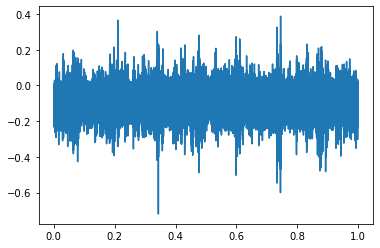

In [13]:
# plot first bearing channel
fig, ax = plt.subplots()

ax.plot(
    np.arange(0,df.shape[0], dtype='float64') / (20.48 * 10**3), # make x-axis in seconds
    df['b1_ch1'] # acceleration data
)

We will want to "detrend" and window the signal -- this is a basic signal processing step.

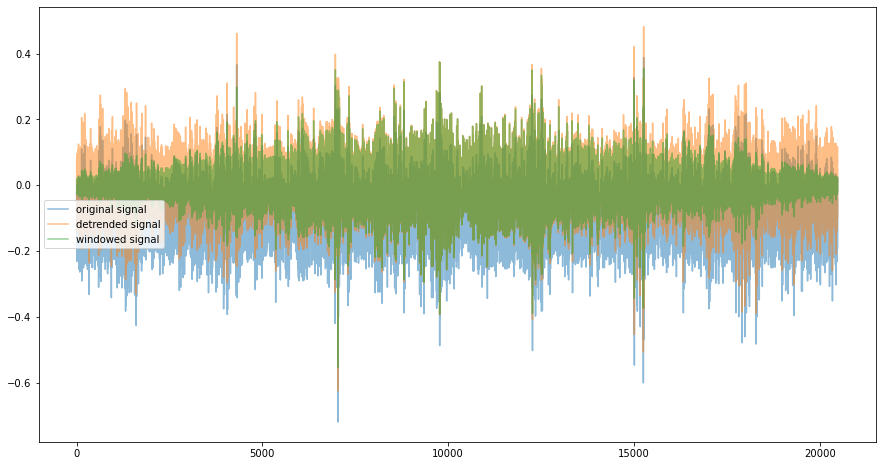

In [14]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['b1_ch1'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['b1_ch1'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 3)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

Use a function to create the FFT (`create_fft`), and another function to plot the time and frequency domains (`create_time_frequency_plot`).

Import those functions first.

In [16]:
from src.features.build_features import create_fft
from src.visualization.visualize_data import create_time_frequency_plot, plot_freq_peaks

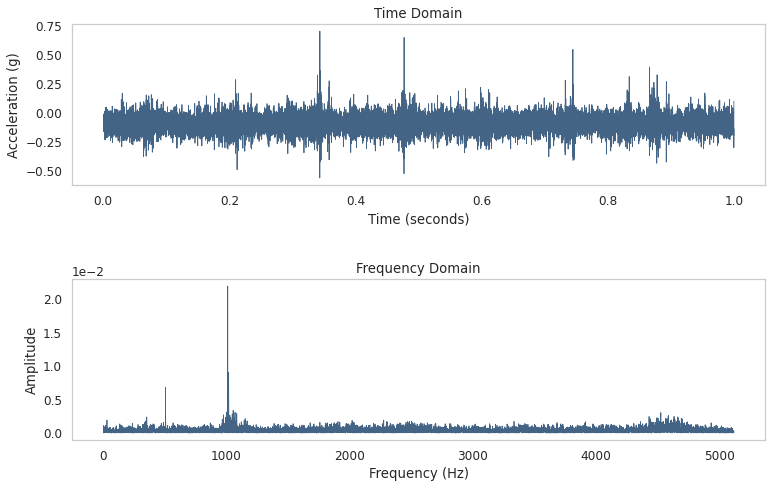

In [17]:
# create fft
x, y, xf, yf = create_fft(df, y_name='b1_ch2', sample_freq=20480.0, window='kaiser', beta=3)

# plot
create_time_frequency_plot(x, y, xf, yf, save_plot=False)

It is interesting to look at the peaks in the frequency domain plot, since different peaks can correspond to different parts of the bearing.

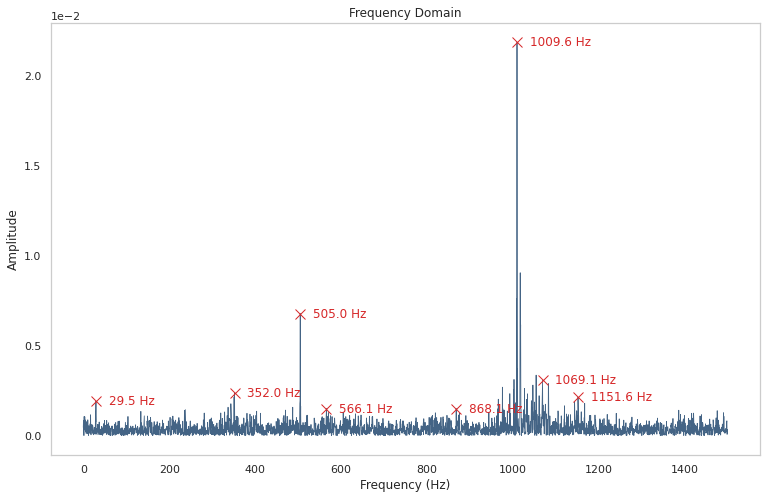

In [19]:
# only plot to 1500 Hz
plot_freq_peaks(xf, yf, max_freq_to_plot=1500, peak_height=0.0015, peak_distance=50)

## 2.1 Build Spectrograms
We will create a spectrogram of each run. A spectrogram is merely a "stack" of FFTs over time.

First, get the name of all the files in the folder.
### 2.1.1 Aside: Getting File Names

In [23]:
date_list = sorted(os.listdir(folder_1st))
date_list[:10] # check to see it makes sense...

['2003.10.22.12.06.24',
 '2003.10.22.12.09.13',
 '2003.10.22.12.14.13',
 '2003.10.22.12.19.13',
 '2003.10.22.12.24.13',
 '2003.10.22.12.29.13',
 '2003.10.22.12.34.13',
 '2003.10.22.12.39.13',
 '2003.10.22.12.44.13',
 '2003.10.22.12.49.13']

The names are a bit clunky. Let's convert them all to UNIX timestamps.

In [24]:
# from https://stackoverflow.com/a/9637908/9214620
s = '2003.10.22.12.06.24'
t = time.mktime(datetime.datetime.strptime(s, "%Y.%m.%d.%H.%M.%S").timetuple())
print(t)

1066849584.0


In [25]:
s.replace('.', '_')

'2003_10_22_12_06_24'

To make sure it makes sense, convert back to a readable format.

In [26]:
print(datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S'))

2003-10-22 12:06:24


### 2.1.2 Calculate FFT for Each Signal
We'll calculate the FFT for each signal. This will be stored in a pandas dataframe, with each new column being a new signal.

In [27]:
start_time = '2003.10.22.12.06.24'
start_time = time.mktime(datetime.datetime.strptime(start_time, "%Y.%m.%d.%H.%M.%S").timetuple())

In [32]:
def build_spectrogram_df(folder, date_list, channel_name='b3_ch5', start_time='2003.10.22.12.06.24', col_day_increment=False,
                         col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']):
    '''function that builds the spectrogram data'''
    
    # convert start_time to unix timestamp
    start_time = time.mktime(datetime.datetime.strptime(start_time, "%Y.%m.%d.%H.%M.%S").timetuple())

    # instantiate dataframe for the spectrogram
    dft = pd.DataFrame()
       
    # dictionary to store any labels
    labels_dict = {}

    # iterate through each date that samples were taken
    # date_list should be sorted from earliest to latest
    for i, sample_name in enumerate(date_list):
        # convert sample_name to unix timestamp
        unix_timestamp = time.mktime(datetime.datetime.strptime(sample_name, "%Y.%m.%d.%H.%M.%S").timetuple())
        date_nice_format = datetime.datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S') # reformat date

        # open the file containing the measurements
        df = pd.read_csv(folder / sample_name, sep='\t', names=col_names)

        # create fft
        create_fft(df, y_name=channel_name, sample_freq=20480.0, window='kaiser', beta=3)
#         xf, yf = create_fft(df, y_name=channel_name, sample_freq=20480.0, show_plot=False, window='kaiser', beta=3)
        # xf, yf = create_fft(df, x_name='Time', y_name=channel_name, sample_freq=20000.0, show_plot=False, window='kaiser', beta=3)

        # change sample name slightly to change '.' to '_' (personal preference)
        sample_name = sample_name.replace('.', '_')

        # append the time increments
        time_increment_seconds = unix_timestamp-start_time
        time_increment_days = time_increment_seconds /(60 * 60 * 24)
        
        # create new column for the current sample_name FFT
        if col_day_increment == False:
            dft[date_nice_format] = yf
        if col_day_increment == True:
            dft[str(time_increment_days)] = yf

        # create new dictionary key and values to store lable info
        labels_dict[sample_name] = [date_nice_format, sample_name, unix_timestamp, time_increment_seconds, time_increment_days]

    dft = dft.set_index(xf, drop=True) # index as frequency (Hz)
    return dft, labels_dict

Let's look at bearing 1, channel 1. This bearing did not fail in this run.

In [33]:
folder_1st = folder_raw_data / '1st_test'

date_list = sorted(os.listdir(folder_1st))

df_spec, labels_dict = build_spectrogram_df(folder_1st, date_list, channel_name='b1_ch1', start_time='2003.10.22.12.06.24')
df_spec.head()

,2003-10-22 12:06:24,2003-10-22 12:09:13,2003-10-22 12:14:13,2003-10-22 12:19:13,2003-10-22 12:24:13,2003-10-22 12:29:13,2003-10-22 12:34:13,2003-10-22 12:39:13,2003-10-22 12:44:13,2003-10-22 12:49:13,...,2003-11-25 15:17:32,2003-11-25 15:27:32,2003-11-25 15:37:32,2003-11-25 15:47:32,2003-11-25 15:57:32,2003-11-25 16:07:32,2003-11-25 23:13:21,2003-11-25 23:19:56,2003-11-25 23:29:56,2003-11-25 23:39:56
0.000000,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,...,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458,0.000458
0.500049,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,...,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853,0.000853
1.000098,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,...,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609,0.000609
1.500146,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
2.000195,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,...,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062


Plot the spectrogram.

In [35]:
import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings

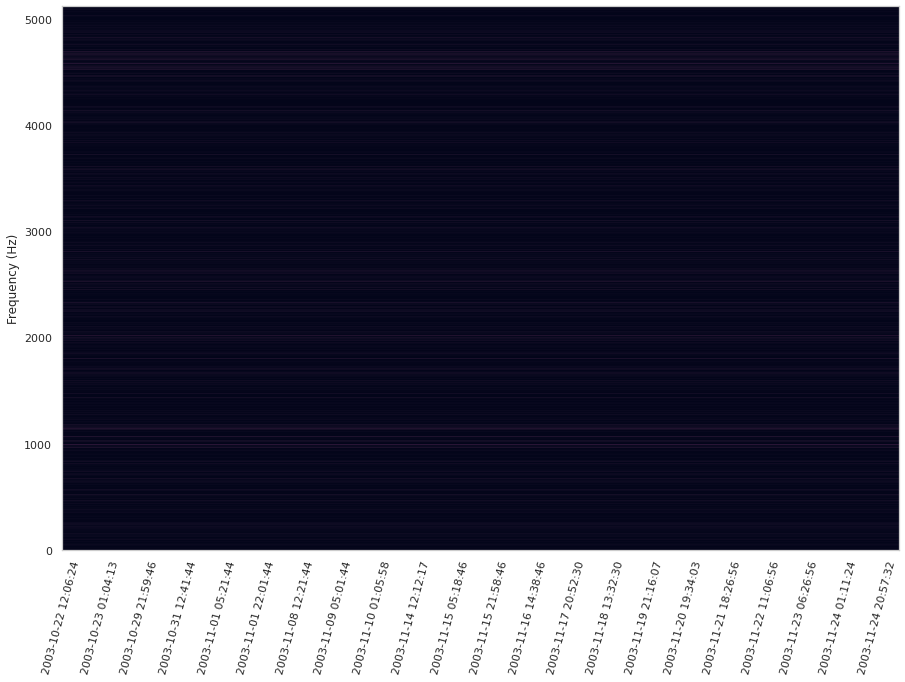

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec)

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()